In [1]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model.bin"

#file to download to run model:  
#1) https://howardhsu.github.io/dataset/ for domain embedding (need to download this!)

In [2]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [3]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

## No Clean

In [4]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task1.csv')

In [5]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [6]:
encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values

print('num of aspect tags: {}'.format(len(encoder.classes_)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2


0

In [7]:
print(len(sentences))
print(len(aspect_tags))

3501
3501


In [8]:
print(max(map(lambda x: len(x), sentences)))

84


In [9]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, aspect_tags, sent_len=83):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                mask[sx, wx] = 1
                train_y[sx, wx] = aspect_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, 2)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [10]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, domain_emb, num_classes=3, dropout=0.5):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.domain_embedding = torch.nn.Embedding(domain_emb.shape[0], domain_emb.shape[1])
        self.domain_embedding.weight = torch.nn.Parameter(torch.from_numpy(domain_emb), requires_grad=False)
        self.conv1 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 5, padding=2)
        self.conv2 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 3, padding=1)

        self.dropout = torch.nn.Dropout(dropout)

        self.conv3 = torch.nn.Conv1d(256, 256, 5, padding=2)
        self.conv4 = torch.nn.Conv1d(256, 256, 5, padding=2)

        self.lstm = nn.LSTM(256, hidden_size=128, num_layers=1, bidirectional=True, batch_first=True)

        self.linear_ae = torch.nn.Linear(256, num_classes)

    def forward(self, x_train):
        x_emb = torch.cat((self.gen_embedding(x_train), self.domain_embedding(x_train)), dim=2)

        x_emb = self.dropout(x_emb).transpose(1, 2)

        x_conv = torch.nn.functional.relu(torch.cat((self.conv1(x_emb.float()), self.conv2(x_emb.float())), dim=1))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv3(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv4(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = x_conv.transpose(1, 2)

        x_lstm, (hidden, cell) = self.lstm(x_conv)

        x_logit = self.linear_ae(x_lstm)

        return x_logit

In [12]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'restaurant_emb.vec'
res_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

fn = DATA_DIR + 'laptop_emb.vec'
lap_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

res_domain_embedding = np.concatenate([res_domain_embedding, lap_domain_embedding], axis=0)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, aspect_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [13]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_ASPECT_TAGS = 2

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding, res_domain_embedding, num_classes=2), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [14]:
history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()

        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



epoch 0
	train_loss:0.517 valid_loss:0.421
	train_acc:85.11% valid_acc:86.12%
	train_f1:0.797 valid_f1:0.797
	train_confusion_matrix:
[[  113  6678]
 [  698 42063]]
	valid_confusion_matrix:
[[    0  1794]
 [    0 11132]]


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]



epoch 1
	train_loss:0.403 valid_loss:0.403
	train_acc:86.41% valid_acc:86.12%
	train_f1:0.801 valid_f1:0.797
	train_confusion_matrix:
[[    0  6751]
 [    0 42926]]
	valid_confusion_matrix:
[[    0  1794]
 [    0 11132]]


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]



epoch 2
	train_loss:0.396 valid_loss:0.393
	train_acc:86.30% valid_acc:86.12%
	train_f1:0.800 valid_f1:0.797
	train_confusion_matrix:
[[    0  6769]
 [    0 42645]]
	valid_confusion_matrix:
[[    0  1794]
 [    0 11132]]


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]



epoch 3
	train_loss:0.382 valid_loss:0.376
	train_acc:86.41% valid_acc:86.12%
	train_f1:0.801 valid_f1:0.797
	train_confusion_matrix:
[[    0  6725]
 [    0 42749]]
	valid_confusion_matrix:
[[    0  1794]
 [    0 11132]]


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]



epoch 4
	train_loss:0.364 valid_loss:0.353
	train_acc:86.38% valid_acc:86.12%
	train_f1:0.801 valid_f1:0.797
	train_confusion_matrix:
[[    0  6733]
 [    0 42704]]
	valid_confusion_matrix:
[[    0  1794]
 [    0 11132]]


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]



epoch 5
	train_loss:0.331 valid_loss:0.314
	train_acc:86.33% valid_acc:86.12%
	train_f1:0.800 valid_f1:0.797
	train_confusion_matrix:
[[    0  6781]
 [    0 42827]]
	valid_confusion_matrix:
[[    0  1794]
 [    0 11132]]


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]



epoch 6
	train_loss:0.288 valid_loss:0.277
	train_acc:86.39% valid_acc:86.39%
	train_f1:0.802 valid_f1:0.810
	train_confusion_matrix:
[[   37  6694]
 [   19 42570]]
	valid_confusion_matrix:
[[   86  1708]
 [   51 11081]]


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



epoch 7
	train_loss:0.255 valid_loss:0.242
	train_acc:88.50% valid_acc:89.79%
	train_f1:0.861 valid_f1:0.886
	train_confusion_matrix:
[[ 1786  5004]
 [  702 42121]]
	valid_confusion_matrix:
[[  747  1047]
 [  273 10859]]


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 8
	train_loss:0.214 valid_loss:0.209
	train_acc:91.42% valid_acc:91.81%
	train_f1:0.909 valid_f1:0.916
	train_confusion_matrix:
[[ 3758  2987]
 [ 1262 41535]]
	valid_confusion_matrix:
[[ 1176   618]
 [  441 10691]]


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 9
	train_loss:0.193 valid_loss:0.198
	train_acc:92.39% valid_acc:92.33%
	train_f1:0.922 valid_f1:0.921
	train_confusion_matrix:
[[ 4546  2209]
 [ 1560 41180]]
	valid_confusion_matrix:
[[ 1194   600]
 [  392 10740]]


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 10
	train_loss:0.184 valid_loss:0.191
	train_acc:92.71% valid_acc:92.51%
	train_f1:0.926 valid_f1:0.923
	train_confusion_matrix:
[[ 4692  2069]
 [ 1539 41203]]
	valid_confusion_matrix:
[[ 1216   578]
 [  390 10742]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 11
	train_loss:0.176 valid_loss:0.185
	train_acc:93.07% valid_acc:92.29%
	train_f1:0.930 valid_f1:0.923
	train_confusion_matrix:
[[ 4806  1962]
 [ 1465 41244]]
	valid_confusion_matrix:
[[ 1276   518]
 [  478 10654]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 12
	train_loss:0.171 valid_loss:0.182
	train_acc:93.24% valid_acc:92.99%
	train_f1:0.931 valid_f1:0.929
	train_confusion_matrix:
[[ 4793  1941]
 [ 1409 41415]]
	valid_confusion_matrix:
[[ 1268   526]
 [  380 10752]]


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 13
	train_loss:0.168 valid_loss:0.181
	train_acc:93.38% valid_acc:92.77%
	train_f1:0.933 valid_f1:0.927
	train_confusion_matrix:
[[ 4821  1898]
 [ 1382 41444]]
	valid_confusion_matrix:
[[ 1292   502]
 [  432 10700]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 14
	train_loss:0.163 valid_loss:0.177
	train_acc:93.55% valid_acc:92.90%
	train_f1:0.934 valid_f1:0.929
	train_confusion_matrix:
[[ 4875  1873]
 [ 1322 41480]]
	valid_confusion_matrix:
[[ 1361   433]
 [  485 10647]]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



epoch 15
	train_loss:0.162 valid_loss:0.172
	train_acc:93.59% valid_acc:93.25%
	train_f1:0.935 valid_f1:0.931
	train_confusion_matrix:
[[ 4962  1798]
 [ 1368 41267]]
	valid_confusion_matrix:
[[ 1266   528]
 [  344 10788]]


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 16
	train_loss:0.159 valid_loss:0.173
	train_acc:93.69% valid_acc:93.26%
	train_f1:0.936 valid_f1:0.932
	train_confusion_matrix:
[[ 4967  1793]
 [ 1327 41387]]
	valid_confusion_matrix:
[[ 1295   499]
 [  372 10760]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 17
	train_loss:0.155 valid_loss:0.168
	train_acc:93.86% valid_acc:93.41%
	train_f1:0.938 valid_f1:0.933
	train_confusion_matrix:
[[ 5022  1770]
 [ 1274 41481]]
	valid_confusion_matrix:
[[ 1311   483]
 [  369 10763]]


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 18
	train_loss:0.152 valid_loss:0.169
	train_acc:94.09% valid_acc:93.53%
	train_f1:0.940 valid_f1:0.933
	train_confusion_matrix:
[[ 5077  1674]
 [ 1247 41440]]
	valid_confusion_matrix:
[[ 1260   534]
 [  302 10830]]


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


epoch 19
	train_loss:0.149 valid_loss:0.159
	train_acc:94.12% valid_acc:93.73%
	train_f1:0.940 valid_f1:0.936
	train_confusion_matrix:
[[ 5097  1686]
 [ 1230 41576]]
	valid_confusion_matrix:
[[ 1317   477]
 [  334 10798]]


(0.8, 1.0)

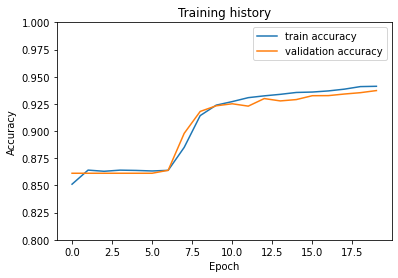

In [17]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.8, 1])

In [18]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_aspect_tags.extend(pred_tags)
            final_true_aspect_tags.extend(label)

    final_pred_aspect_tags = torch.stack(final_pred_aspect_tags).cpu()
    final_true_aspect_tags = torch.stack(final_true_aspect_tags).cpu()
        
    print(classification_report(final_true_aspect_tags, final_pred_aspect_tags, 
                                target_names=encoder.classes_))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.bin


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

              precision    recall  f1-score   support

          AT       0.78      0.85      0.81      1794
         NAT       0.98      0.96      0.97     11132

    accuracy                           0.95     12926
   macro avg       0.88      0.91      0.89     12926
weighted avg       0.95      0.95      0.95     12926



## Clean

In [19]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task1_cleaned.csv')

In [20]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [21]:
encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values

print('num of aspect tags: {}'.format(len(encoder.classes_)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2


0

In [22]:
print(len(sentences))
print(len(aspect_tags))

3501
3501


In [23]:
print(max(map(lambda x: len(x), sentences)))

80


In [25]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, aspect_tags, sent_len=83):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                mask[sx, wx] = 1
                train_y[sx, wx] = aspect_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, 2)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [26]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, domain_emb, num_classes=3, dropout=0.5):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.domain_embedding = torch.nn.Embedding(domain_emb.shape[0], domain_emb.shape[1])
        self.domain_embedding.weight = torch.nn.Parameter(torch.from_numpy(domain_emb), requires_grad=False)
        self.conv1 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 5, padding=2)
        self.conv2 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 3, padding=1)

        self.dropout = torch.nn.Dropout(dropout)

        self.conv3 = torch.nn.Conv1d(256, 256, 5, padding=2)
        self.conv4 = torch.nn.Conv1d(256, 256, 5, padding=2)

        self.lstm = nn.LSTM(256, hidden_size=128, num_layers=1, bidirectional=True, batch_first=True)

        self.linear_ae = torch.nn.Linear(256, num_classes)

    def forward(self, x_train):
        x_emb = torch.cat((self.gen_embedding(x_train), self.domain_embedding(x_train)), dim=2)

        x_emb = self.dropout(x_emb).transpose(1, 2)

        x_conv = torch.nn.functional.relu(torch.cat((self.conv1(x_emb.float()), self.conv2(x_emb.float())), dim=1))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv3(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv4(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = x_conv.transpose(1, 2)

        x_lstm, (hidden, cell) = self.lstm(x_conv)

        x_logit = self.linear_ae(x_lstm)

        return x_logit

In [27]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'restaurant_emb.vec'
res_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

fn = DATA_DIR + 'laptop_emb.vec'
lap_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

res_domain_embedding = np.concatenate([res_domain_embedding, lap_domain_embedding], axis=0)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, aspect_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [28]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_ASPECT_TAGS = 2

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding, res_domain_embedding, num_classes=2), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [29]:
history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()

        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]



epoch 0
	train_loss:0.540 valid_loss:0.441
	train_acc:84.38% valid_acc:84.73%
	train_f1:0.774 valid_f1:0.777
	train_confusion_matrix:
[[    8  6689]
 [   49 36401]]
	valid_confusion_matrix:
[[   0 1774]
 [   0 9841]]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



epoch 1
	train_loss:0.434 valid_loss:0.422
	train_acc:84.49% valid_acc:84.73%
	train_f1:0.774 valid_f1:0.777
	train_confusion_matrix:
[[    0  6683]
 [    0 36418]]
	valid_confusion_matrix:
[[   0 1774]
 [   0 9841]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 2
	train_loss:0.415 valid_loss:0.406
	train_acc:84.57% valid_acc:84.73%
	train_f1:0.775 valid_f1:0.777
	train_confusion_matrix:
[[    0  6686]
 [    0 36638]]
	valid_confusion_matrix:
[[   0 1774]
 [   0 9841]]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



epoch 3
	train_loss:0.397 valid_loss:0.388
	train_acc:84.51% valid_acc:84.73%
	train_f1:0.774 valid_f1:0.777
	train_confusion_matrix:
[[    0  6699]
 [    0 36535]]
	valid_confusion_matrix:
[[   0 1774]
 [   0 9841]]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



epoch 4
	train_loss:0.370 valid_loss:0.353
	train_acc:84.48% valid_acc:84.73%
	train_f1:0.774 valid_f1:0.777
	train_confusion_matrix:
[[    0  6697]
 [    0 36454]]
	valid_confusion_matrix:
[[   0 1774]
 [   0 9841]]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



epoch 5
	train_loss:0.331 valid_loss:0.311
	train_acc:84.53% valid_acc:84.74%
	train_f1:0.774 valid_f1:0.777
	train_confusion_matrix:
[[    0  6702]
 [    0 36615]]
	valid_confusion_matrix:
[[   1 1773]
 [   0 9841]]


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



epoch 6
	train_loss:0.295 valid_loss:0.281
	train_acc:85.55% valid_acc:87.25%
	train_f1:0.810 valid_f1:0.853
	train_confusion_matrix:
[[  800  5860]
 [  401 36280]]
	valid_confusion_matrix:
[[ 565 1209]
 [ 272 9569]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 7
	train_loss:0.263 valid_loss:0.250
	train_acc:88.25% valid_acc:89.80%
	train_f1:0.870 valid_f1:0.891
	train_confusion_matrix:
[[ 2792  3883]
 [ 1178 35220]]
	valid_confusion_matrix:
[[ 932  842]
 [ 343 9498]]


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 8
	train_loss:0.231 valid_loss:0.226
	train_acc:90.77% valid_acc:91.12%
	train_f1:0.904 valid_f1:0.908
	train_confusion_matrix:
[[ 4081  2553]
 [ 1432 35123]]
	valid_confusion_matrix:
[[1102  672]
 [ 359 9482]]


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]



epoch 9
	train_loss:0.208 valid_loss:0.212
	train_acc:91.68% valid_acc:91.39%
	train_f1:0.915 valid_f1:0.914
	train_confusion_matrix:
[[ 4507  2148]
 [ 1447 35126]]
	valid_confusion_matrix:
[[1254  520]
 [ 480 9361]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 10
	train_loss:0.196 valid_loss:0.199
	train_acc:92.31% valid_acc:91.82%
	train_f1:0.922 valid_f1:0.918
	train_confusion_matrix:
[[ 4779  1882]
 [ 1433 35006]]
	valid_confusion_matrix:
[[1272  502]
 [ 448 9393]]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



epoch 11
	train_loss:0.188 valid_loss:0.196
	train_acc:92.54% valid_acc:91.92%
	train_f1:0.924 valid_f1:0.919
	train_confusion_matrix:
[[ 4870  1815]
 [ 1405 35099]]
	valid_confusion_matrix:
[[1303  471]
 [ 467 9374]]


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



epoch 12
	train_loss:0.183 valid_loss:0.193
	train_acc:92.67% valid_acc:92.22%
	train_f1:0.926 valid_f1:0.921
	train_confusion_matrix:
[[ 4934  1772]
 [ 1402 35198]]
	valid_confusion_matrix:
[[1255  519]
 [ 385 9456]]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



epoch 13
	train_loss:0.177 valid_loss:0.191
	train_acc:93.06% valid_acc:92.45%
	train_f1:0.930 valid_f1:0.924
	train_confusion_matrix:
[[ 4996  1640]
 [ 1340 34977]]
	valid_confusion_matrix:
[[1299  475]
 [ 402 9439]]


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



epoch 14
	train_loss:0.173 valid_loss:0.184
	train_acc:93.17% valid_acc:92.56%
	train_f1:0.931 valid_f1:0.926
	train_confusion_matrix:
[[ 4990  1684]
 [ 1274 35340]]
	valid_confusion_matrix:
[[1337  437]
 [ 427 9414]]


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



epoch 15
	train_loss:0.174 valid_loss:0.182
	train_acc:93.11% valid_acc:92.84%
	train_f1:0.930 valid_f1:0.928
	train_confusion_matrix:
[[ 5053  1637]
 [ 1343 35200]]
	valid_confusion_matrix:
[[1327  447]
 [ 385 9456]]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



epoch 16
	train_loss:0.169 valid_loss:0.184
	train_acc:93.51% valid_acc:92.64%
	train_f1:0.934 valid_f1:0.926
	train_confusion_matrix:
[[ 5068  1601]
 [ 1203 35307]]
	valid_confusion_matrix:
[[1330  444]
 [ 411 9430]]


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



epoch 17
	train_loss:0.164 valid_loss:0.183
	train_acc:93.66% valid_acc:92.88%
	train_f1:0.936 valid_f1:0.928
	train_confusion_matrix:
[[ 5056  1562]
 [ 1177 35384]]
	valid_confusion_matrix:
[[1321  453]
 [ 374 9467]]


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]



epoch 18
	train_loss:0.163 valid_loss:0.179
	train_acc:93.66% valid_acc:93.19%
	train_f1:0.936 valid_f1:0.930
	train_confusion_matrix:
[[ 5187  1510]
 [ 1224 35235]]
	valid_confusion_matrix:
[[1269  505]
 [ 286 9555]]


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


epoch 19
	train_loss:0.159 valid_loss:0.177
	train_acc:93.66% valid_acc:92.95%
	train_f1:0.936 valid_f1:0.929
	train_confusion_matrix:
[[ 5048  1586]
 [ 1152 35372]]
	valid_confusion_matrix:
[[1327  447]
 [ 372 9469]]


(0.8, 0.95)

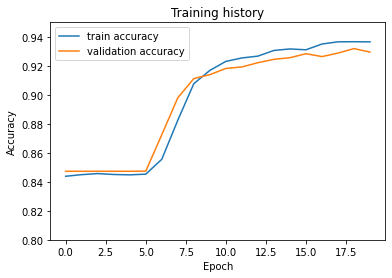

In [32]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.8, 0.95])

In [33]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_aspect_tags.extend(pred_tags)
            final_true_aspect_tags.extend(label)

    final_pred_aspect_tags = torch.stack(final_pred_aspect_tags).cpu()
    final_true_aspect_tags = torch.stack(final_true_aspect_tags).cpu()
        
    print(classification_report(final_true_aspect_tags, final_pred_aspect_tags, 
                                target_names=encoder.classes_))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.bin


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

              precision    recall  f1-score   support

          AT       0.77      0.87      0.82      1774
         NAT       0.98      0.95      0.96      9841

    accuracy                           0.94     11615
   macro avg       0.87      0.91      0.89     11615
weighted avg       0.94      0.94      0.94     11615

